# Knowledge Distillation

**Module 03 | Notebook 2 of 5**

Knowledge distillation trains a smaller "student" model to mimic a larger "teacher" model.

## Learning Objectives

By the end of this notebook, you will be able to:
1. Understand the teacher-student paradigm
2. Implement KL divergence loss for distillation
3. Train a distilled model from scratch
4. Compare performance before and after distillation

### Prerequisites
- Basic PyTorch knowledge (Training loops, Loss functions)
- Familiarity with Cross Entropy Loss

---

In [1]:
%%capture
# Install core libraries:
# - accelerate: for efficient training loop handling
# - evaluate: for metric calculation
!pip install transformers datasets accelerate evaluate torch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoConfig, get_scheduler
)
from datasets import load_dataset
from torch.utils.data import DataLoader
import evaluate
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## How Distillation Works

### Traditional Training vs. Distillation

```
TRADITIONAL TRAINING:
┌───────────┐     Hard Labels       ┌───────────┐
│   Input   │────────────────────→  │  Student  │  Loss: CrossEntropy
└───────────┘     [0, 1, 0]         └───────────┘

DISTILLATION:
┌───────────┐                        
│   Input   │                        
└─────┬─────┘                        
      │                              
      ├──────────→ ┌───────────┐     Soft Labels (probabilities)
      │            │  Teacher  │────→ [0.05, 0.90, 0.05]
      │            └───────────┘            │
      │                                     │ KL Divergence
      │                                     ▼
      └──────────→ ┌───────────┐     ────────────────
                   │  Student  │────→ [0.10, 0.85, 0.05]
                   └───────────┘
```

### Why Soft Labels?

Soft labels contain **more information** than hard labels:

| Label Type | Example | Information Content |
|------------|---------|--------------------|
| Hard | [0, 1, 0] ("cat") | Only the correct class |
| Soft | [0.05, 0.90, 0.05] | "Mostly cat, slightly similar to dog and bird" |

### 💡 Key Concept: Dark Knowledge

Geoffrey Hinton, who popularized this technique, referred to the information hidden in the soft probabilities as **"Dark Knowledge"**. 

For example, in a digit classifier, if the input is a '2' that looks a bit like a '7', the teacher might output:
- P(2) = 0.9
- P(7) = 0.09
- P(3) = 0.001

This tells the student: "It's a 2, but it's structurally more similar to a 7 than a 3". Hard labels ([0, 1, 0...]) throw away this valuable structural information.

### The Distillation Loss

```
L_total = α × L_distill + (1-α) × L_student

Where:
  L_distill = KL(teacher_soft_logits, student_soft_logits) × T²
  L_student = CrossEntropy(student_logits, hard_labels)
  T = Temperature (higher = softer probabilities)
  α = Weighting factor (typically 0.5-0.9)
```

---

## Load Teacher and Student Models

In [3]:
# Teacher: A fine-tuned BERT model
teacher_name = "distilbert-base-uncased-finetuned-sst-2-english"
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_name)
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_name).to(device)
teacher_model.eval()  # Teacher is always in eval mode

teacher_params = sum(p.numel() for p in teacher_model.parameters())
print(f"Teacher: {teacher_name}")
print(f"  Parameters: {teacher_params:,}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Teacher: distilbert-base-uncased-finetuned-sst-2-english
  Parameters: 66,955,010


In [4]:
# Student: A smaller model (we'll create a smaller DistilBERT)
# For real distillation, you'd use an even smaller architecture
# Here we'll use the same architecture but show the training process

student_name = "distilbert-base-uncased"  # Base model, not fine-tuned
student_tokenizer = AutoTokenizer.from_pretrained(student_name)
student_model = AutoModelForSequenceClassification.from_pretrained(
    student_name,
    num_labels=2
).to(device)

student_params = sum(p.numel() for p in student_model.parameters())
print(f"\nStudent: {student_name}")
print(f"  Parameters: {student_params:,}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Student: distilbert-base-uncased
  Parameters: 66,955,010


---

## Prepare the Dataset

In [5]:
# Load SST-2 dataset (same as teacher was trained on)
dataset = load_dataset("glue", "sst2")

print("Dataset:")
print(f"  Train: {len(dataset['train'])} examples")
print(f"  Validation: {len(dataset['validation'])} examples")

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset:
  Train: 67349 examples
  Validation: 872 examples


In [6]:
# Use subset for faster training
train_size = 2000
val_size = 500

train_data = dataset['train'].shuffle(seed=42).select(range(train_size))
val_data = dataset['validation'].shuffle(seed=42).select(range(val_size))

# Tokenization
def tokenize_function(examples):
    return teacher_tokenizer(
        examples['sentence'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

train_tokenized = train_data.map(tokenize_function, batched=True)
val_tokenized = val_data.map(tokenize_function, batched=True)

# Set format for PyTorch
train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Create dataloaders
train_loader = DataLoader(train_tokenized, batch_size=16, shuffle=True)
val_loader = DataLoader(val_tokenized, batch_size=32)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

---

## Implement Distillation Loss

### Understanding KL Divergence

Before implementing our distillation loss, let's understand **KL Divergence (Kullback-Leibler Divergence)**:

> **KL Divergence** measures how one probability distribution differs from another. In mathematical terms, it quantifies the "extra bits" needed to encode data from distribution P using distribution Q.

In distillation, we use KL divergence because:
- We want the student's probability distribution to match the teacher's distribution
- KL divergence penalizes the student when its probabilities diverge from the teacher's "soft" probabilities
- Unlike MSE loss, KL divergence is specifically designed for comparing probability distributions

The formula is: $D_{KL}(P || Q) = \sum_i P(i) \log \frac{P(i)}{Q(i)}$

**Why the T² scaling?** When we divide logits by temperature T, the gradients during backpropagation are scaled by 1/T². Multiplying by T² compensates for this, ensuring gradients remain at a reasonable magnitude regardless of the temperature used.

In [7]:
class DistillationLoss(nn.Module):
    """
    Distillation loss combining soft label matching and hard label classification.
    
    L_total = α × L_distill + (1-α) × L_student
    """
    def __init__(self, temperature=4.0, alpha=0.7):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')
    
    def forward(self, student_logits, teacher_logits, labels):
        # 1. Soft labels from teacher and student (with Temperature scaling)
        #    We divide logits by T to 'soften' the distribution before softmax
        teacher_soft = F.softmax(teacher_logits / self.temperature, dim=-1)
        student_soft = F.log_softmax(student_logits / self.temperature, dim=-1)
        
        # 2. Distillation loss (KL divergence between soft distributions)
        #    We scale by T^2 because gradients scale with 1/T^2 during backprop
        distill_loss = self.kl_loss(student_soft, teacher_soft) * (self.temperature ** 2)
        
        # 3. Student loss (standard classification on hard labels)
        #    Often called the 'Task Loss' - ensures true accuracy doesn't drift
        student_loss = self.ce_loss(student_logits, labels)
        
        # 4. Combined weighted loss
        total_loss = self.alpha * distill_loss + (1 - self.alpha) * student_loss
        
        return total_loss, distill_loss, student_loss

# Initialize loss function
distill_criterion = DistillationLoss(temperature=4.0, alpha=0.7)
print("Distillation loss initialized with:")
print(f"  Temperature: {distill_criterion.temperature}")
print(f"  Alpha: {distill_criterion.alpha}")

Distillation loss initialized with:
  Temperature: 4.0
  Alpha: 0.7


### Understanding Temperature

Temperature controls how "soft" the probability distribution is:

| Temperature | Effect |
|-------------|--------|
| T = 1 | Original distribution |
| T = 2-5 | Smoother distribution (recommended) |
| T > 10 | Very uniform distribution |

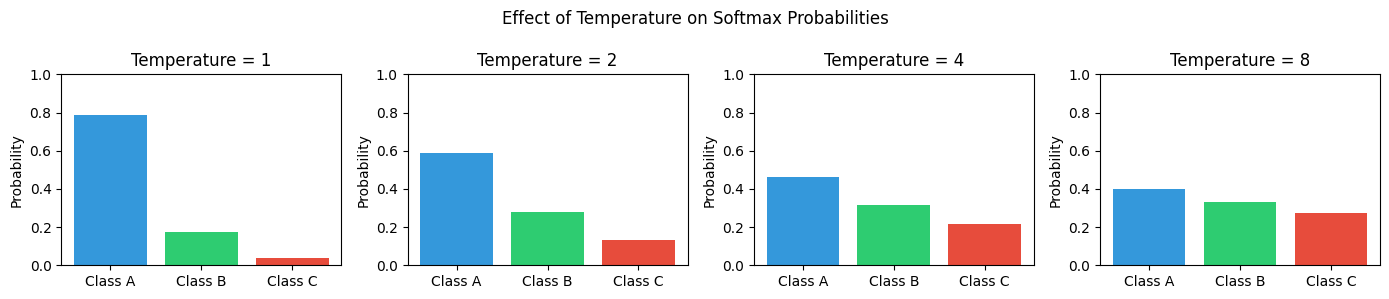

In [8]:
# Visualize temperature effect
import matplotlib.pyplot as plt

logits = torch.tensor([2.0, 0.5, -1.0])
temps = [1, 2, 4, 8]

fig, axes = plt.subplots(1, 4, figsize=(14, 3))

for ax, T in zip(axes, temps):
    probs = F.softmax(logits / T, dim=-1).numpy()
    ax.bar(['Class A', 'Class B', 'Class C'], probs, color=['#3498db', '#2ecc71', '#e74c3c'])
    ax.set_ylim(0, 1)
    ax.set_title(f'Temperature = {T}')
    ax.set_ylabel('Probability')

plt.suptitle('Effect of Temperature on Softmax Probabilities', fontsize=12)
plt.tight_layout()
plt.show()

---

## Train the Student Model

In [ ]:
# Optimizer and scheduler
optimizer = AdamW(student_model.parameters(), lr=2e-5, weight_decay=0.01)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)

### Understanding the Distillation Training Loop

The `train_epoch` function below is the heart of knowledge distillation. Here's what happens at a high level:

```
For each batch of data:
┌─────────────────────────────────────────────────────────────────┐
│  1. TEACHER INFERENCE (no gradients)                           │
│     • Feed input to teacher model                              │
│     • Get teacher's "soft" predictions (logits)                │
│     • torch.no_grad() saves memory - we don't train teacher    │
├─────────────────────────────────────────────────────────────────┤
│  2. STUDENT INFERENCE (with gradients)                         │
│     • Feed same input to student model                         │
│     • Get student's predictions (logits)                       │
│     • Gradients tracked for backpropagation                    │
├─────────────────────────────────────────────────────────────────┤
│  3. COMPUTE DISTILLATION LOSS                                  │
│     • Compare student vs teacher (KL divergence on soft labels)│
│     • Compare student vs ground truth (cross-entropy)          │
│     • Combine with alpha weighting                             │
├─────────────────────────────────────────────────────────────────┤
│  4. BACKPROPAGATION (only on student)                          │
│     • Compute gradients w.r.t. student parameters              │
│     • Update student weights to minimize combined loss         │
└─────────────────────────────────────────────────────────────────┘
```

> 💡 **Key Insight**: The teacher is frozen (eval mode, no gradients). Only the student learns. The teacher acts as a "knowledge oracle" providing rich supervision signals.

In [10]:
def train_epoch(student_model, teacher_model, train_loader, optimizer, scheduler, criterion, device):
    """Train for one epoch."""
    student_model.train()
    total_loss = 0
    total_distill_loss = 0
    total_student_loss = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Get teacher predictions (no gradient)
        with torch.no_grad():
            teacher_outputs = teacher_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            teacher_logits = teacher_outputs.logits
        
        # Get student predictions
        student_outputs = student_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        student_logits = student_outputs.logits
        
        # Calculate distillation loss
        loss, distill_loss, student_loss = criterion(
            student_logits, teacher_logits, labels
        )
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        total_distill_loss += distill_loss.item()
        total_student_loss += student_loss.item()
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'distill': f'{distill_loss.item():.4f}'
        })
    
    return {
        'total_loss': total_loss / len(train_loader),
        'distill_loss': total_distill_loss / len(train_loader),
        'student_loss': total_student_loss / len(train_loader)
    }

In [11]:
def evaluate_model(model, val_loader, device):
    """Evaluate model accuracy."""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    return correct / total

In [12]:
# Evaluate teacher first (baseline)
teacher_acc = evaluate_model(teacher_model, val_loader, device)
print(f"Teacher Accuracy: {teacher_acc:.2%}")

# Evaluate un-distilled student
student_acc_before = evaluate_model(student_model, val_loader, device)
print(f"Student Accuracy (before distillation): {student_acc_before:.2%}")

Teacher Accuracy: 90.80%
Student Accuracy (before distillation): 52.20%


In [13]:
# Training loop
print("\n" + "="*50)
print("Starting Distillation Training")
print("="*50)

history = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)
    
    # Train
    train_metrics = train_epoch(
        student_model, teacher_model, train_loader,
        optimizer, lr_scheduler, distill_criterion, device
    )
    
    # Evaluate
    student_acc = evaluate_model(student_model, val_loader, device)
    
    history.append({
        'epoch': epoch + 1,
        'loss': train_metrics['total_loss'],
        'accuracy': student_acc
    })
    
    print(f"Loss: {train_metrics['total_loss']:.4f}")
    print(f"  - Distillation Loss: {train_metrics['distill_loss']:.4f}")
    print(f"  - Student Loss: {train_metrics['student_loss']:.4f}")
    print(f"Validation Accuracy: {student_acc:.2%}")

print("\n" + "="*50)
print("Distillation Complete!")
print("="*50)


Starting Distillation Training

Epoch 1/3
------------------------------


Training: 100%|██████████| 125/125 [00:28<00:00,  4.39it/s, loss=2.8627, distill=3.5854]


Loss: 2.7978
  - Distillation Loss: 3.7468
  - Student Loss: 0.5836
Validation Accuracy: 83.60%

Epoch 2/3
------------------------------


Training: 100%|██████████| 125/125 [00:29<00:00,  4.18it/s, loss=0.4886, distill=0.6535]


Loss: 1.0775
  - Distillation Loss: 1.3795
  - Student Loss: 0.3730
Validation Accuracy: 86.00%

Epoch 3/3
------------------------------


Training: 100%|██████████| 125/125 [00:32<00:00,  3.87it/s, loss=0.4916, distill=0.6409]


Loss: 0.5297
  - Distillation Loss: 0.6629
  - Student Loss: 0.2191
Validation Accuracy: 86.20%

Distillation Complete!


---

## Compare Results

In [14]:
# Final evaluation
student_acc_after = evaluate_model(student_model, val_loader, device)

print("\n" + "="*50)
print("Results Comparison")
print("="*50)
print(f"\nTeacher Accuracy:                    {teacher_acc:.2%}")
print(f"Student Accuracy (before):           {student_acc_before:.2%}")
print(f"Student Accuracy (after distill):    {student_acc_after:.2%}")
print(f"\nImprovement:                         +{(student_acc_after - student_acc_before)*100:.1f}%")
print(f"Gap to Teacher:                      {(teacher_acc - student_acc_after)*100:.1f}%")


Results Comparison

Teacher Accuracy:                    90.80%
Student Accuracy (before):           52.20%
Student Accuracy (after distill):    86.20%

Improvement:                         +34.0%
Gap to Teacher:                      4.6%


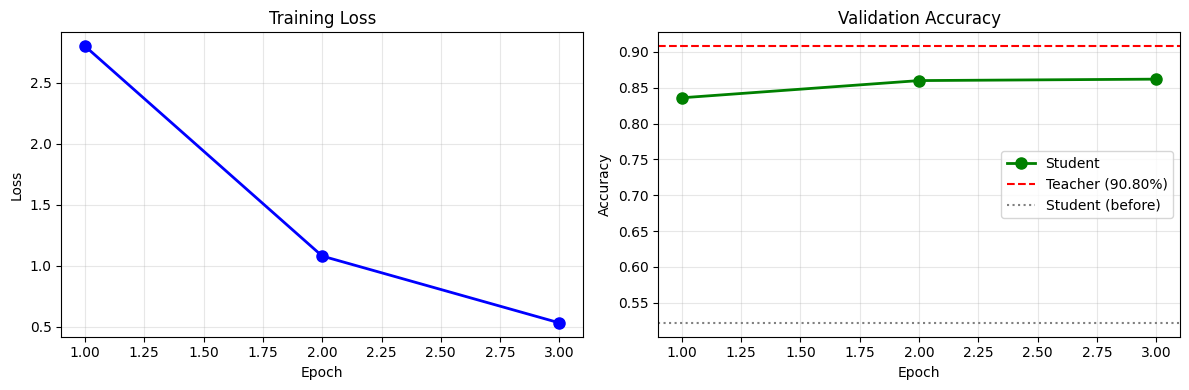

In [15]:
# Visualize training progress
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = [h['epoch'] for h in history]
losses = [h['loss'] for h in history]
accuracies = [h['accuracy'] for h in history]

# Loss plot
axes[0].plot(epochs, losses, 'b-o', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs, accuracies, 'g-o', linewidth=2, markersize=8, label='Student')
axes[1].axhline(y=teacher_acc, color='r', linestyle='--', label=f'Teacher ({teacher_acc:.2%})')
axes[1].axhline(y=student_acc_before, color='gray', linestyle=':', label=f'Student (before)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Test the Distilled Model

In [16]:
# Test on new examples
test_texts = [
    "This movie was absolutely wonderful!",
    "Terrible waste of time.",
    "The acting was superb but the plot was confusing."
]

print("Comparison on Test Examples:")
print("="*60)

for text in test_texts:
    inputs = teacher_tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    
    with torch.no_grad():
        teacher_out = teacher_model(**inputs).logits
        student_out = student_model(**inputs).logits
    
    teacher_probs = F.softmax(teacher_out, dim=-1)[0]
    student_probs = F.softmax(student_out, dim=-1)[0]
    
    teacher_pred = "POSITIVE" if teacher_probs[1] > 0.5 else "NEGATIVE"
    student_pred = "POSITIVE" if student_probs[1] > 0.5 else "NEGATIVE"
    
    print(f"\nText: {text}")
    print(f"  Teacher: {teacher_pred} ({teacher_probs[1]:.2%} positive)")
    print(f"  Student: {student_pred} ({student_probs[1]:.2%} positive)")

Comparison on Test Examples:

Text: This movie was absolutely wonderful!
  Teacher: POSITIVE (99.99% positive)
  Student: POSITIVE (99.97% positive)

Text: Terrible waste of time.
  Teacher: NEGATIVE (0.02% positive)
  Student: NEGATIVE (0.12% positive)

Text: The acting was superb but the plot was confusing.
  Teacher: NEGATIVE (0.67% positive)
  Student: NEGATIVE (0.57% positive)


### Challenge: Experiment with Hyperparameters

Here is what typically happens when you tune these parameters:

<details>
<summary><strong>💡 Hints & Interpretations</strong></summary>

**1. Temperature (T)**
- **Low T (e.g., 1)**: Probability calculation is sharp. Dark knowledge (small probabilities) might be drowned out.
- **High T (e.g., 8)**: Distribution flattens. The model pays closer attention to the relationships between incorrect classes. Too high, and everything becomes uniform noise.

**2. Alpha (α)**
- **Higher α (e.g., 0.9)**: Trust the teacher more. Useful if your labelled dataset is small or noisy, but the teacher is very robust.
- **Lower α**: Trust the ground truth labels more. Useful if the student needs to excel at the base task without worrying too much about mimicking the teacher's exact nuances.

**3. Epochs**
Distillation often helps the student converge *faster* and generalize better, but it might still need more epochs to reach the teacher's level than simply training on hard labels, as the objective is complex.
</details>

In [17]:
# TODO: Experiment with different distillation settings:

# 1. Try different temperatures (T = 1, 2, 8, 16)
#    - Record accuracy for each
#    - Which temperature works best?

# 2. Try different alpha values (α = 0.3, 0.5, 0.7, 0.9)
#    - α closer to 1 = more weight on distillation loss
#    - α closer to 0 = more weight on hard labels

# 3. What happens with more training epochs?

# Your solution:


---

## When to Use Knowledge Distillation

### ✅ Use Distillation When:

| Scenario | Why It Helps |
|----------|-------------|
| Large teacher model available | You have a powerful model that learned rich representations |
| Need smaller deployment model | Edge devices, mobile apps, or latency-critical applications |
| Have unlabeled or weakly-labeled data | Teacher can generate "soft labels" for unlabeled data |
| Want to preserve teacher's "dark knowledge" | Soft labels capture class relationships hard labels miss |
| Teacher-student size gap is significant | The bigger the gap, the more knowledge there is to transfer |

### ❌ Don't Use Distillation When:

| Scenario | Why It Doesn't Help |
|----------|--------------------|
| Teacher and student are same size | No efficiency gain; just train the model directly |
| No access to teacher model | You need the teacher's outputs for distillation |
| Need model interpretability | Distilled models inherit the "black box" nature of the teacher |
| Teacher model is already small | Little room for compression; consider other techniques |

### 📊 Comparison with Other Compression Techniques

| Technique | What It Does | When to Use |
|-----------|--------------|-------------|
| **Distillation** | Trains smaller model to mimic larger one | Large accuracy-size gap acceptable |
| **Pruning** | Removes unimportant weights from existing model | Want to compress without retraining architecture |
| **Quantization** | Reduces numerical precision (FP32 → INT8) | Need smaller memory footprint with minimal accuracy loss |

💡 **Pro tip**: These techniques can be combined! E.g., distill first, then quantize the student model.

---

## Key Takeaways

### Core Concepts

1. **Distillation** transfers knowledge from a large model to a smaller one
2. **Soft labels** contain more information than hard labels (the "dark knowledge")
3. **Temperature** controls how soft the probability distribution is
4. **Combined loss** uses both distillation and classification objectives
5. Student can achieve **95-99%** of teacher performance

### ⚠️ Limitations to Keep in Mind

- **Student can't exceed teacher performance**: The student's ceiling is the teacher's accuracy
- **Requires access to teacher model**: You need to run inference on the teacher during training
- **Training takes longer than standard training**: Each batch needs both teacher and student forward passes
- **Best with large teacher-student gap**: If models are similar size, benefits are minimal
- **Sensitive to hyperparameters**: Temperature (T) and alpha (α) need careful tuning

### 🌍 Real-World Examples

| Original Model | Distilled Model | Use Case |
|----------------|-----------------|----------|
| BERT-base (110M params) | DistilBERT (66M params) | 40% smaller, 60% faster, 97% accuracy |
| GPT-3 (175B params) | Various smaller models | API cost reduction, edge deployment |
| LLaMA-70B | LLaMA-7B with distillation | Mobile and on-device inference |

---

## Next Steps

Continue to `03_pruning.ipynb` for weight pruning techniques!